# **PROJECT IDS 561: SENTIMENTAL ANALYSIS OF YELP REVIEWS**

**LINKING THE COLAB TO GOOGLE DRIVE**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/IDS561_final_project/yelp_dataset

/content/drive/My Drive/IDS561_final_project/yelp_dataset


In [3]:
!ls
!pwd

business.json		       spark-3.3.2-bin-hadoop3.tgz.2
review.json		       spark-3.3.2-bin-hadoop3.tgz.3
spark-3.3.2-bin-hadoop3        spark-3.3.2-bin-hadoop3.tgz.4
spark-3.3.2-bin-hadoop3.tgz    user.json
spark-3.3.2-bin-hadoop3.tgz.1
/content/drive/My Drive/IDS561_final_project/yelp_dataset


**INSTALLING SPARK**

In [4]:
!tar -xvf spark-3.1.2-bin-hadoop3.2.tgz

# Installing the library to install the spark in python
!pip install -q findspark
!pip install pyspark

tar: spark-3.1.2-bin-hadoop3.2.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=30abea8226a551d69bbc853b9ba751c8717eb918a6c39594c131912806cedbc9
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


**IMPORTING LIBRARIES TO BE USED IN THE PROJECT**

In [5]:
import re
import sys
import string
import pandas as pd
from pyspark import SparkConf, SparkContext, HiveContext
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from heapq import nlargest
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
#importing libraries for spark
from pyspark import *
from pyspark.python.pyspark.shell import spark
from pyspark.sql.functions import *
from datetime import datetime
from pyspark.sql.functions import udf, to_date, to_utc_timestamp, lit, col
from pyspark.sql.types import StringType, DateType
from pyspark import SparkContext
from pyspark.sql import SQLContext

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.5.0
      /_/

Using Python version 3.10.12 (main, Jun 11 2023 05:26:28)
Spark context Web UI available at http://45428fd0d8ea:4040
Spark context available as 'sc' (master = local[*], app id = local-1695913047130).
SparkSession available as 'spark'.


In [7]:
from pyspark.sql.functions import split,explode
from pyspark.sql.functions import *
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

from pyspark.mllib.classification import SVMModel, SVMWithSGD
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors as MLLibVectors
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import *
from pyspark.ml.feature import IDF
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder


from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

from pyspark.mllib.classification import SVMModel, SVMWithSGD
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors as MLLibVectors


In [8]:
# importing libraries for pyspark.ml features and clustering
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [9]:
from wordcloud import WordCloud, STOPWORDS

**INITIALISING A LOCAL SPARK SESSION**

In [10]:
# Opening local Spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# **DATA EXPLORATION ANALYSIS**

**LOADING DATASETS**

In [11]:
yelp_review = spark.read.json('/content/drive/My Drive/IDS561_final_project/yelp_dataset/review.json')
yelp_business = spark.read.json('/content/drive/My Drive/IDS561_final_project/yelp_dataset/business.json')
yelp_user = spark.read.json('/content/drive/My Drive/IDS561_final_project/yelp_dataset/user.json')

**DATA EXPLORATION**

In [12]:
yelp_business.show(5)
yelp_review.show(5)
yelp_user.show(5)

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{NULL, NULL, NULL...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|Santa Barbara|                NULL|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{NULL, NULL, NULL...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|       Affton|{8:0-18:30, 0:0-0...|      1| 38.551126|  -90.335695|    

In [13]:
yelp_business.dtypes
yelp_review.dtypes
yelp_user.dtypes

[('average_stars', 'double'),
 ('compliment_cool', 'bigint'),
 ('compliment_cute', 'bigint'),
 ('compliment_funny', 'bigint'),
 ('compliment_hot', 'bigint'),
 ('compliment_list', 'bigint'),
 ('compliment_more', 'bigint'),
 ('compliment_note', 'bigint'),
 ('compliment_photos', 'bigint'),
 ('compliment_plain', 'bigint'),
 ('compliment_profile', 'bigint'),
 ('compliment_writer', 'bigint'),
 ('cool', 'bigint'),
 ('elite', 'string'),
 ('fans', 'bigint'),
 ('friends', 'string'),
 ('funny', 'bigint'),
 ('name', 'string'),
 ('review_count', 'bigint'),
 ('useful', 'bigint'),
 ('user_id', 'string'),
 ('yelping_since', 'string')]

In [14]:
print("Number of reviews: {}".format(yelp_review.count()))
print("Number of business: {}".format(yelp_business.count()))
print("Number of users: {}".format(yelp_user.count()))

Number of reviews: 6990280
Number of business: 150346
Number of users: 1987897


**1. The top 'most reviewed' businesses**

In [15]:
# Inorder to look at the reviews and their count we filter the data for which star rating is greater than 3
review_filtered = yelp_review.filter('stars >3')
grouped_review = review_filtered.groupby('business_id').count()
sort_review = grouped_review.sort('count',ascending=False)

business_1 = yelp_business.select('business_id','name','categories')
review_business_name = business_1.join(sort_review,'business_id','inner')
business_reviewed = review_business_name.limit(10)
business_reviewed.show()

+--------------------+--------------------+--------------------+-----+
|         business_id|                name|          categories|count|
+--------------------+--------------------+--------------------+-----+
|sk2lZI4zmuGAccd3D...|Boyd Hill Nature ...|Active Life, Park...|   33|
|83IeQHroXEctmMpK1...|The Richel D'Ambr...|Hair Salons, Day ...|   39|
|6e85By5Jy7MMnW2cE...|          Wanderwell|Tax Services, Boo...|    5|
|WKMJwqnfZKsAae75R...|Roast Coffeehouse...|Coffee & Tea, Foo...|   31|
|jIBjZcqVOU4pOVT-s...|           IRB Sushi|Sushi Bars, Resta...|   34|
|NQhyMw8SOU1HB-V9X...|Champion Chevrole...|Automotive, Auto ...|   20|
|q6661I3CGW0UB740E...|         India House|Home & Garden, Ho...|   32|
|lpbt16sSm4BTcfeq4...|           Super Wok|Restaurants, Chinese|   38|
|AwmeLVLEfdFoCa0La...|      The Beer Store|Food, Beer, Wine ...|   16|
|RZ-FNTXvqHKngyLGD...|Gaetano's of West...|Italian, Food, Re...|   15|
+--------------------+--------------------+--------------------+-----+



**2. The count of top business categories/industries**

In [16]:
from pyspark.sql.functions import split, explode
category = yelp_business.select('categories')
individual_category = category.select(explode(split('categories', ',')).alias('category'))
grouped_category = individual_category.groupby('category').count()
top_category = grouped_category.sort('count',ascending=False)
top_category.show(10,truncate=False)


+-----------------+-----+
|category         |count|
+-----------------+-----+
| Restaurants     |36978|
| Food            |20998|
| Shopping        |18915|
|Restaurants      |15290|
| Home Services   |10563|
| Nightlife       |9990 |
| Beauty & Spas   |9907 |
| Bars            |9130 |
| Health & Medical|8832 |
| Local Services  |8556 |
+-----------------+-----+
only showing top 10 rows



**3. Count of different star ratings in our dataset**

In [17]:
rating = yelp_business.select('stars')
group_rating = rating.groupby('stars').count()
rating_top = group_rating.sort('count',ascending=False)
rating_top.show(truncate=False)

+-----+-----+
|stars|count|
+-----+-----+
|4.0  |31125|
|4.5  |27181|
|3.5  |26519|
|3.0  |18453|
|5.0  |16307|
|2.5  |14316|
|2.0  |9527 |
|1.5  |4932 |
|1.0  |1986 |
+-----+-----+



**4. Top cities with maximum number of businesses**

In [18]:
locations = yelp_business.select('business_id','city')
review_city = yelp_review.select('business_id')
merge_city = locations.join(review_city,'business_id','inner')
grouped_review_city = merge_city.groupby('city').count()
most_reviewed_city = grouped_review_city.groupby('city').sum()
most_reviewed_city.sort('sum(count)',ascending=False).show(10)

+-------------+----------+
|         city|sum(count)|
+-------------+----------+
| Philadelphia|    967552|
|  New Orleans|    635364|
|        Tampa|    454889|
|    Nashville|    451571|
|       Tucson|    404880|
| Indianapolis|    361489|
|         Reno|    351573|
|Santa Barbara|    269630|
|  Saint Louis|    253437|
|        Boise|    105366|
+-------------+----------+
only showing top 10 rows



**5. Printing the number of reviews we have for each star rating**

+-----+-------+
|stars|  count|
+-----+-------+
|  1.0|1069561|
|  2.0| 544240|
|  3.0| 691934|
|  4.0|1452918|
|  5.0|3231627|
+-----+-------+



<Axes: xlabel='stars', ylabel='count'>

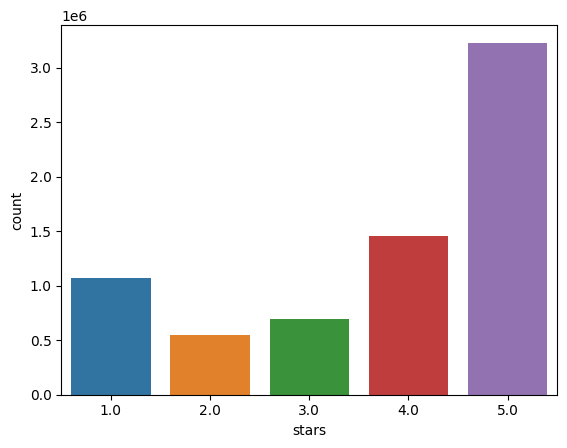

In [19]:
yelp_review_1= yelp_review.groupBy('stars').agg(count('review_id').alias('count')).sort('stars')
yelp_review_1.show()
temp987=yelp_review_1.toPandas()
sns.barplot(x='stars', y='count', data=temp987)

In [20]:
# Checking for null values
yelp_review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



**6. Visualization of businesses open**

In [21]:
df_open = yelp_business.groupBy('is_open').count().toPandas()
df_open

,is_open,count
0,0,30648
1,1,119698


<Axes: xlabel='is_open', ylabel='count'>

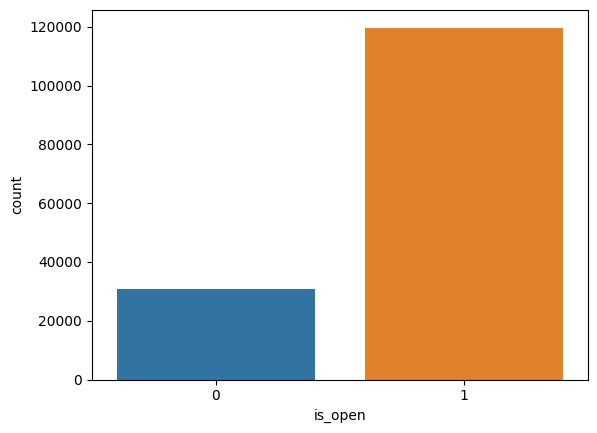

In [22]:
sns.barplot(x='is_open', y='count', data=df_open)

**7. Visualization of top cities by number of businesses**

In [23]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import split,explode
plt.style.use('ggplot')

In [24]:
topcity = merge_city.groupBy('city').count().sort('count').orderBy(['count'], ascending=[0]).toPandas()
topcity.head()

,city,count
0,Philadelphia,967552
1,New Orleans,635364
2,Tampa,454889
3,Nashville,451571
4,Tucson,404880


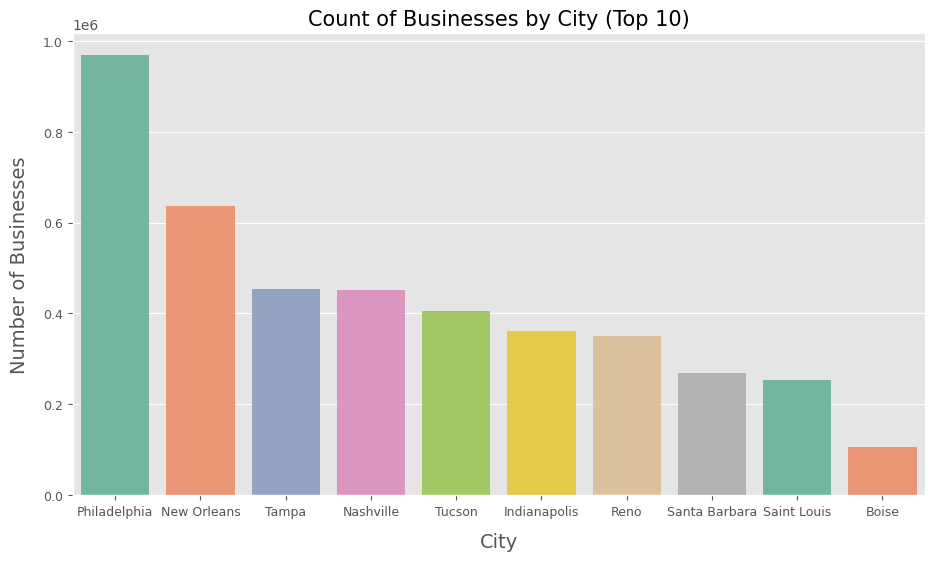

In [25]:
plt.figure(figsize=(11, 6))
sns.barplot(x=topcity['city'].values[:10], y=topcity['count'].values[:10], palette=sns.color_palette("Set2"))
plt.ylabel('Number of Businesses', fontsize=14, labelpad=10)
plt.xlabel('City', fontsize=14, labelpad=10)
plt.title('Count of Businesses by City (Top 10)', fontsize=15)
plt.tick_params(labelsize=9)
plt.xticks(rotation=0)
plt.show()

**8. Visulazation of top cities by number of restaurants**

In [26]:
topcat = individual_category.groupBy('category').count().sort('count').orderBy(['count'], ascending=[0]).toPandas()
topcat.head()

,category,count
0,Restaurants,36978
1,Food,20998
2,Shopping,18915
3,Restaurants,15290
4,Home Services,10563


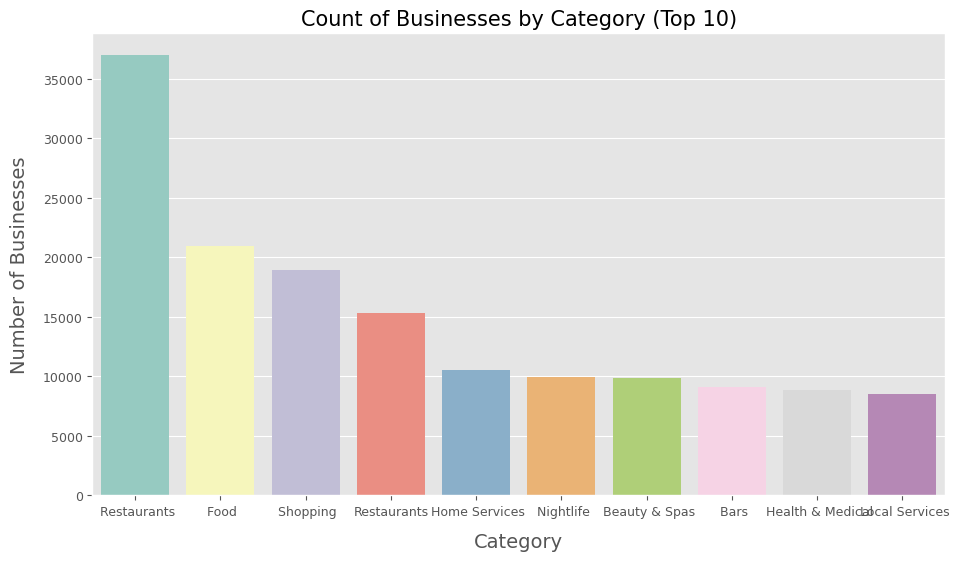

In [27]:
plt.figure(figsize=(11, 6))
sns.barplot(x=topcat['category'][:10], y=topcat['count'][:10], palette=sns.color_palette("Set3"))
plt.ylabel('Number of Businesses', fontsize=14, labelpad=10)
plt.xlabel('Category', fontsize=14, labelpad=10)
plt.title('Count of Businesses by Category (Top 10)', fontsize=15)
plt.tick_params(labelsize=9)
plt.xticks(rotation=0)
plt.show()

**9. Number of reviews over time(year)**

In [28]:
from pyspark.sql import functions as f
import datetime
from pyspark.sql.functions import year
from pyspark.sql.functions import month

In [29]:
df = yelp_review.withColumn('date', f.to_date(f.unix_timestamp('date', 'yyyy-MM-dd HH:mm:ss').cast('timestamp')))
df = df.withColumn('year', year(col('date')))
df = df.withColumn('stars', df['stars'].cast('int'))

In [30]:
reviews_res = df.groupBy('year').count().orderBy('year').toPandas()
reviews_res = reviews_res.dropna()
reviews_res.head()

,year,count
0,2005,854
1,2006,3853
2,2007,15363
3,2008,48226
4,2009,74387


Text(0.5, 1.0, 'Total reviews recieved over time')

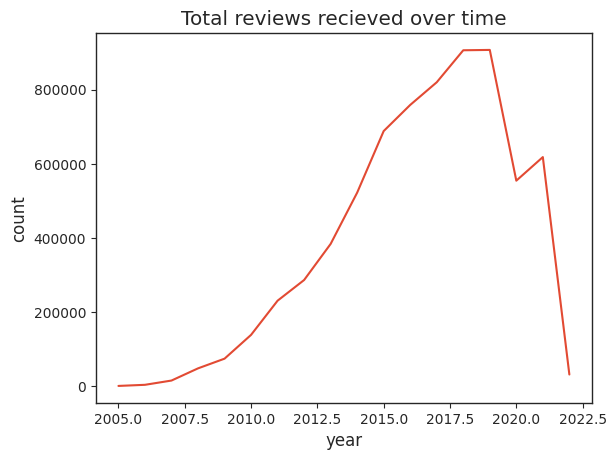

In [31]:
sns.set_style('ticks')
sns.lineplot(x="year", y="count", data=reviews_res).set_title('Total reviews recieved over time')